🍁**هدف : پیاده سازی یک مدل مینی بارت برای خلاصه سازی** 🍁


🟦 model-type : **bart**

🟦 enc-num : **3**

🟦 dec-num : **3**

🟦 d_model : **256**

🟦 n_heads : **4**

🟦 tokenizer : **facebook/bart-base**

🟦 dataset : **cnn/dailymail**

🟦 train-size : **3000** (برای نمونه بسیار کم است.به دلخواه افزایش دهید)



In [ ]:
!pip install lightning

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger

### **BART-Model**

🟥 **شکل کلی مدل های بارت** 🟥   

🟪 **encoder-stack** -> 🟪 **decoder-stack**

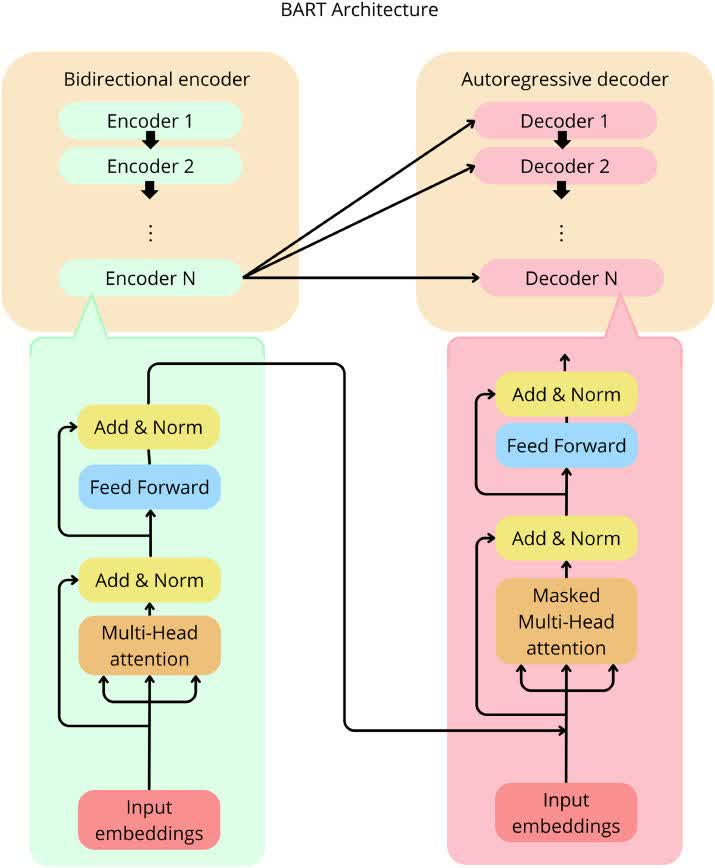

Encoder-stack : list [ EncoderLayers ]

↪ Encoder-Layer :**SelfAttn** + **FeedForward** + **NormLayer**

Decoder-stack : list [ DecoderLayers ]

↪ Decoder-Layer : **SelfAttn** + **CrossAttn** + **FeedForward** + **NormLayer**

 فقط در دیکودر استفاده میشه CrossAttn از

توجه کنید که خروجی بلاک انکودر به تمام لایه های بلاک دیکودر وارد میشه

 گزاشتیم mem نام این ورودی رو در کد

 به کار میره CrossAttn این ورودی در


In [4]:
class FFN(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super().__init__()
    self.lin1 = nn.Linear(d_model,d_ff)
    self.lin2 = nn.Linear(d_ff,d_model)
    self.dropout = nn.Dropout(dropout)
  def forward(self,x):
    return self.lin2(self.dropout(F.gelu(self.lin1(x))))

In [5]:
class SelfAttn(nn.Module):
  def __init__(self,d_model,n_heads,dropout=0.1):
    super().__init__()
    self.attn = nn.MultiheadAttention(d_model,n_heads,dropout=dropout,batch_first=True)
    self.ln = nn.LayerNorm(d_model)
  def forward(self,x,attn_mask=None,key_padding_mask=None):
    h,_ = self.attn(x,x,x,attn_mask=attn_mask,key_padding_mask=key_padding_mask,need_weights=False)
    return self.ln(x+h)

In [6]:
class CrossAttn(nn.Module):
  def __init__(self,d_model,n_heads,dropout=0.1):
    super().__init__()
    self.attn = nn.MultiheadAttention(d_model,n_heads,dropout=dropout,batch_first=True)
    self.ln = nn.LayerNorm(d_model)
  def forward(self,x,mem,attn_mask=None,key_padding_mask=None,mem_padding_mask=None):
    h,_ = self.attn(x,mem,mem,attn_mask=attn_mask,key_padding_mask=key_padding_mask)
    return self.ln(x+h)

In [7]:
class EncoderLayer(nn.Module):
  def __init__(self,d_model,n_heads,d_ff,dropout=0.1):
    super().__init__()
    self.self_attn = SelfAttn(d_model,n_heads,dropout)
    self.ffn = FFN(d_model,d_ff,dropout)
    self.ln = nn.LayerNorm(d_model)
  def forward(self,x,key_padding_mask=None):
    x = self.self_attn(x,key_padding_mask=key_padding_mask)
    return self.ln(x+self.ffn(x))

In [8]:
class DecoderLayer(nn.Module):
  def __init__(self,d_model,n_heads,d_ff,dropout=0.1):
    super().__init__()
    self.self_attn = SelfAttn(d_model,n_heads,dropout)
    self.cross_attn = CrossAttn(d_model,n_heads,dropout)
    self.ffn = FFN(d_model,d_ff,dropout)
    self.ln = nn.LayerNorm(d_model)
  def forward(self,x,mem,tgt_key_padding_mask=None,mem_key_padding_mask=None,causal_mask=None):
    x = self.self_attn(x,attn_mask=causal_mask,key_padding_mask=tgt_key_padding_mask)
    x = self.cross_attn(x,mem,mem_padding_mask=mem_key_padding_mask)
    return self.ln(x+self.ffn(x))

In [22]:
class MiniBART(nn.Module):
  def __init__(self,vocab_size,d_model=256,n_heads=4,d_ff=1024,num_enc=3,num_dec=3,max_len=512):
    super().__init__()
    self.tok_emb = nn.Embedding(vocab_size,d_model)
    self.pos_emb = nn.Embedding(max_len,d_model)
    self.enc_layers = nn.ModuleList([EncoderLayer(d_model,n_heads,d_ff) for _ in range(num_enc)])
    self.dec_layers = nn.ModuleList([DecoderLayer(d_model,n_heads,d_ff) for _ in range(num_dec)])
    self.lm_head = nn.Linear(d_model,vocab_size,bias=False)

  def forward(self,src_ids,tgt_ids):

    def add_pos(x):
      b,L = x.shape
      pos = torch.arange(L,device=x.device).unsqueeze(0).expand(b,L)
      return self.tok_emb(x) + self.pos_emb(pos)

    src = add_pos(src_ids)
    tgt = add_pos(tgt_ids)

    # encoder
    mem = src
    for layer in self.enc_layers:
      mem = layer(mem)

    # causal mask for decoder self-attn
    L = tgt.size(1)
    causal = torch.triu(torch.ones(L,L,device=tgt.device)*float("-inf"),diagonal=1)

    out = tgt
    for layer in self.dec_layers:
      out = layer(out,mem,causal_mask=causal)

    logits = self.lm_head(out)
    return logits

### **Dataset**

In [3]:
dataset = load_dataset("cnn_dailymail","3.0.0")

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [23]:
MAX_INPUT = 512
MAX_TARGET = 128

def prepprocess(batch):
  inputs = tokenizer(
      batch["article"],max_length=MAX_INPUT,padding="max_length",truncation=True
  )
  targets = tokenizer(
      batch["highlights"],max_length=MAX_TARGET,padding="max_length",truncation=True
  )
  inputs["labels"] = targets["input_ids"]
  return inputs

برای این مدل 3000 داده آموزشی خیلی کم است.برای نتیجه بهتر داده آموزشی را بهتر کنید

In [24]:
train_dataset = dataset["train"].select(range(3000))
val_dataset = dataset["validation"].select(range(700))

tokenized_train_data = train_dataset.map(prepprocess,batched=True,remove_columns=train_dataset.column_names)
tokenized_val_data = val_dataset.map(prepprocess,batched=True,remove_columns=val_dataset.column_names)

train_data = tokenized_train_data.with_format("torch")
val_data = tokenized_val_data.with_format("torch")

train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
val_loader = DataLoader(val_data,batch_size=4,shuffle=False)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

### **Lightning Module**

In [25]:
class LitMiniBART(pl.LightningModule):
  def __init__(self,vocab_size,d_model=256,n_heads=4,d_ff=1024,num_enc=3,num_dec=3):
    super().__init__()
    self.model = MiniBART(vocab_size,d_model,n_heads,d_ff,num_enc,num_dec)
    self.loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

  def forward(self,src_ids,tgt_ids):
    return self.model(src_ids,tgt_ids)

  def training_step(self,batch,batch_idx):
    logits = self(batch["input_ids"],batch["labels"])
    shift_logits = logits[:,:-1].contiguous()
    shift_labels = batch["labels"][:,1:].contiguous()
    loss = self.loss_fn(shift_logits.view(-1,shift_logits.size(-1)),shift_labels.view(-1))
    self.log("train_loss",loss,prog_bar=True)
    return loss

  def validation_step(self,batch,batch_idx):
    logits = self(batch["input_ids"],batch["labels"])
    shift_logits = logits[:,:-1].contiguous()
    shift_labels = batch["labels"][:,1:].contiguous()
    loss = self.loss_fn(shift_logits.view(-1,shift_logits.size(-1)),shift_labels.view(-1))
    self.log("val_loss",loss,prog_bar=True)

  def configure_optimizers(self) :
    return torch.optim.AdamW(self.parameters(),lr=5e-4)

### **Train**

In [26]:
logger = CSVLogger("logs",name="MiniBART")

model = LitMiniBART(vocab_size=tokenizer.vocab_size)
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=1,
    precision=16 if torch.cuda.is_available() else 32,
    logger=logger,
    log_every_n_steps=50
)

/usr/local/lib/python3.12/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.util

In [27]:
trainer.fit(model,train_loader,val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MiniBART         | 31.4 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.585   Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MiniBART         |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


### **Test**

In [28]:
def greedy_decode(model,src_text,max_len=64):
  model.eval()
  src_ids = tokenizer(src_text,return_tensors="pt",truncation=True, padding="max_length",max_length=MAX_INPUT)["input_ids"].to(model.device)
  tgt_ids = torch.tensor([[tokenizer.bos_token_id]]).to(model.device)


  for _ in range(max_len):
    logits = model(src_ids,tgt_ids)
    next_token = logits[:,-1].argmax(-1).unsqueeze(0)
    tgt_ids = torch.cat([tgt_ids, next_token],dim=1)
    if next_token.item() == tokenizer.eos_token_id:
      break
  return tokenizer.decode(tgt_ids.squeeze(),skip_special_tokens=True)

In [ ]:
print(greedy_decode(model, dataset["test"][0]["article"]))

برای بدست آوردن نتیجه بهتر، داده آموزش را بیشتر کنید